In [1]:
import pandas as pd
import numpy as np

import util, plotting, analysis

# Data Characteristics
The primary dataset used for analysis in the following section contains 30 seconds of data recorded with an OxiWear prototype device attached to the ear (file: '20201012-180354-9697-6264.csv'). Reference SpO2 and heart rate readings were taken concurrently with a finger-attached pulse oximeter. In this 30 second window, the heart rate was 62-64 BMP and the SpO2 was 96-97% according to this reference. The data consist of a red LED (660 nm) signal and an infrared LED (940 nm) signal and were sampled continuously at 25Hz. 

The first step in the data processing is to decompose the red and infrared signals into AC and DC components. We did so using high-pass and low-pass Butterworth filters, respectively. Below is plotted the original infrared signal (top), the AC component (middle), and the DC component (bottom).


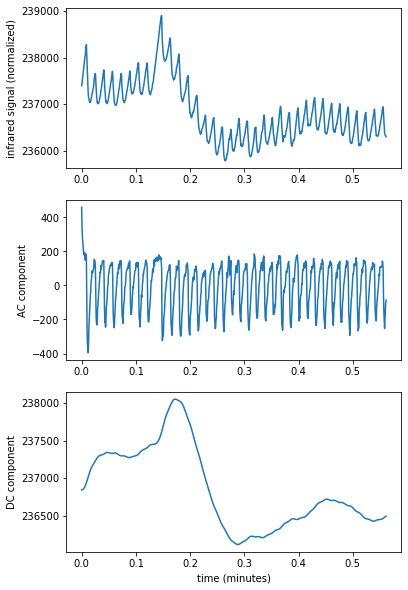

In [2]:
# Load and organize data

csv_data ='spo2-data/proto2/20201012-180354-9697-6264.csv' # 30 seconds


df = pd.read_csv(csv_data) # be aware that some files have a header
red = df['3']
infrared = df['1']
sampling_rate = 24.995
tile_range = [50, 773] # chosen to be approximately continuous when data are looped


data = util.decompose_ACDC(red, infrared, sampling_rate)
data = util.getSpO2(data, tile_range)
plotting.plot_raw_data(data)


# Sampling frequency
First, we consider the ‘sampling frequency’ parameter: the rate at which LEDs flash and photodiodes collect data. The OxiWear device currently operates at a sampling rate of 25Hz, a typical choice for pulse oximeters. Yet, it is possible that a lower sampling frequency would be sufficient. The Nyquest-Shannon sampling theorem states that the minimum adequate frequency to reliably sample a signal is twice the highest frequency signal in the data. For example, to sample heart rate signals, one should sample at least at twice the highest conceivable heart rate (approximately 220 beats per minute), which would be approximately 440 samples per minute or about 8Hz. 

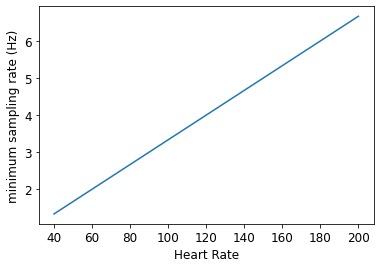

In [3]:
# Nyquest: minimum sampling rate vs heart rate
HR = np.linspace(40,200,200)
plotting.plot_nyquest(HR, 'Heart Rate')

The plot above shows the theoretically minimum sufficient sampling rate as a function of heart rate. While this theorem supplies a baseline for a minimally sufficient sampling rate, real-world factors such as noise may necessitate a higher sampling frequency. 


The appropriate sampling frequency will also depend on the heart rate (signal with lower heart rate can tolerate a lower sampling frequency). It is thus important to ensure the chosen sampling frequency retains accuracy across all potential heart rate values. Here, we employed synthetic data with heart rate ranging from 40 BPM to 220 BMP. We test a variety of sampling rates from 8Hz to 40Hz via linear interpolation.

**Q**: What is the minimum sampling frequency that will yield accurate heart rate measurement?\
**A**: It depends on the magnitude of heart rate. Assuming a maximum heart rate of 220 BPM, theoretically 7.33Hz would be sufficient.

In [4]:
target_HRs = np.arange(40,220,10)
resampled_rates = np.arange(8,51,2)
original_data = -np.tile(data['red_AC'][16:],2) # approx 1 minute of data
original_fq = data['sampling_rate']

error, means, stds = analysis.samplingFq_vs_HR(original_data, original_fq, target_HRs, resampled_rates)
pct_error = (error/means)*100

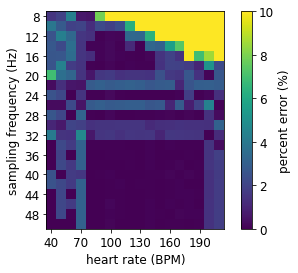

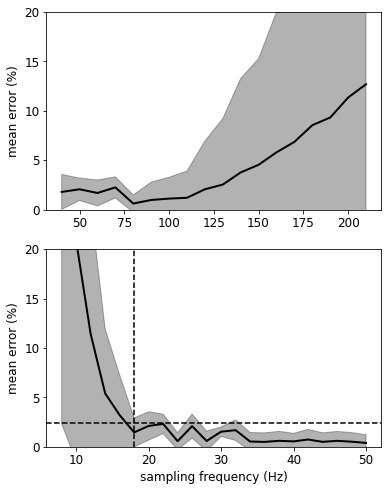

In [5]:
#  plot means
plotting.plot_fq_vs_HR(pct_error, target_HRs, resampled_rates)

Plotted above is the percent error in the estimation of heart rate across heart rate magnitude and sampling frequency. At the top is a heatmap where the color indicates percent error and at the bottom are the same results marginalized across either sampling frequency (top) or heart rate (bottom). As expected, high heart rates (>100BPM)  are subject to error, particularly when sampling frequency is low (<12Hz). However, measurement error stabilizes below 2.5% error by 18Hz suggesting that ~18Hz is sufficient and higher sampling rates do not improve signal reliability.

**Q**: Given empirical data, what is the minimum sampling frequency that will yield accurate heart rate measurement?\
**A**: A sampling rate of 18Hz is sufficient to measure heart rate with less than 2.5% error at all viable heart rate magnitudes. Increasing sampling beyond 18Hz doesn't improve accuracy significantly.

# Sample Duration

Next, we consider the duration of a data sample needed to accurately calculate heart rate. Particularly when the heart rate is slow, a sufficiently long sample is needed to calculate heart rate accurately. For example, if the heart rate is 60 BPM, a one second sample would only capture 1 heart beat and would be too short a duration to calculate heart rate.

In [6]:
sample_durs = [1,2,3,4,5,6,7,8,9,10,15,30,45,60]
error, means, stds = analysis.samplingDur_vs_HR(original_data, original_fq, target_HRs, sample_durs)
pct_error = (error/means)*100

/opt/anaconda3/envs/oxiwear/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/oxiwear/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


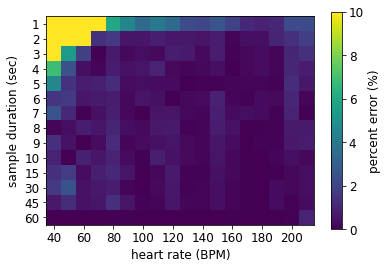

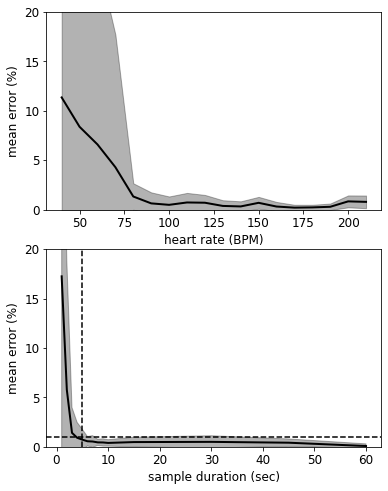

In [7]:
#  plot means
plotting.plot_dur_vs_HR(pct_error, target_HRs, sample_durs)


Plotted above is the percent error in the estimation of heart rate across heart rate magnitude and sample duration. At the top is a heatmap where the color indicates percent error and at the bottom are the same results marginalized across either sample duration (top) or heart rate (bottom). Again as expected, lower heart rates (<80 BPM) are subject to error, particularly when sample duration is low (<4 seconds). Measurement error stabilizes below 1% error by 4 seconds, indicating that a very brief sample duration is sufficient to accurately calculate heart rate.

**Q**: For how long a period do data need to be collected to accurately measure heart rate?\
**A**: ~5 seconds of data is sufficient to accurately measure heart rate across all viable heart rate magnitudes.

# Simulating SpO2 Drops

To simulate SpO2 data, we rely on the time-course of hypoxic episodes observed in the literature (Sun et al _Gas exchange detection of exercise-induced right-to-left shunt in patients with primary pulmonary hypertension._ Circulation 2002). The following parameter choices were tuned to recreate the data from this paper with a focus on capureing the time-course of the initial drop in SpO2 and the level of noise in the data.

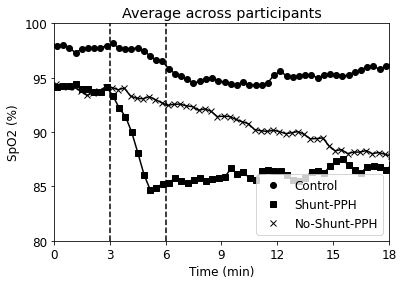

In [8]:


# plot 1: average across patients
    

#  control
params_ctrl = dict()
params_ctrl['baseline_spo2'] = 98
params_ctrl['drop_time_sec'] = 6*60
params_ctrl['recover_time_sec'] = 20*60
params_ctrl['drop_frac'] = 0.85
params_ctrl['noise'] = 15


#  no-shunt-PPH
params_pph_noshunt = dict()
params_pph_noshunt['baseline_spo2'] = 94
params_pph_noshunt['drop_time_sec'] = 14*60
params_pph_noshunt['recover_time_sec'] = 20*60
params_pph_noshunt['drop_frac'] = 0.80
params_pph_noshunt['noise'] = 15


#  shunt PPH case average
params_pph_avg = dict()
params_pph_avg['baseline_spo2'] = 94
params_pph_avg['drop_time_sec'] = 2*60
params_pph_avg['recover_time_sec'] = 90*60
params_pph_avg['drop_frac'] = 0.75
params_pph_avg['noise'] = 15


plotting.plot_fig_1(data, params_ctrl, params_pph_avg, params_pph_noshunt)


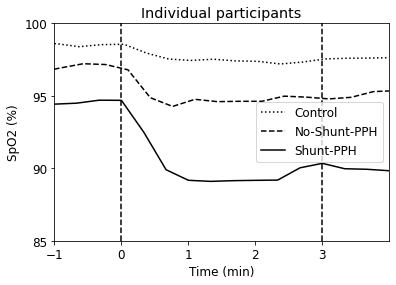

In [9]:

# plot 2: individual patients

#  control individual
params_ctrl_indi = dict()
params_ctrl_indi['baseline_spo2'] = 98.5
params_ctrl_indi['drop_time_sec'] = 10
params_ctrl_indi['recover_time_sec'] = 20*60
params_ctrl_indi['drop_frac'] = 0.95
params_ctrl_indi['noise'] = 15

#  no-shunt-PPH
params_pph_noshunt_indi = dict()
params_pph_noshunt_indi['baseline_spo2'] = 97
params_pph_noshunt_indi['drop_time_sec'] = 30
params_pph_noshunt_indi['recover_time_sec'] = 20*60
params_pph_noshunt_indi['drop_frac'] = 0.90
params_pph_noshunt_indi['noise'] = 15

#  shunt PPH case individual
params_pph_indi = dict()
params_pph_indi['baseline_spo2'] = 94.5
params_pph_indi['drop_time_sec'] = 45
params_pph_indi['recover_time_sec'] = 20*60
params_pph_indi['drop_frac'] = 0.82
params_pph_indi['noise'] = 15


plotting.plot_fig_2(data, params_ctrl_indi, params_pph_noshunt_indi, params_pph_indi)




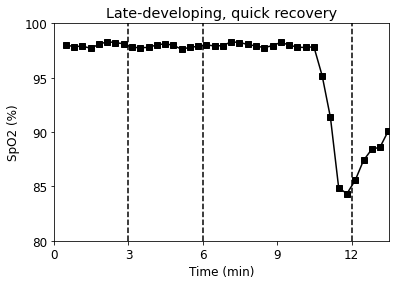

In [10]:
# plot 3: late-developing, quick recovery

#  quick-recovery
params_quick_recov = dict()
params_quick_recov['baseline_spo2'] = 98
params_quick_recov['drop_time_sec'] = 60
params_quick_recov['recover_time_sec'] = 6*60
params_quick_recov['drop_frac'] = 0.60
params_quick_recov['noise'] = 15

plotting.plot_fig_3(data, params_quick_recov)



# Data Update Period

With simulated data in hand, we can now consider the ‘data update period’: the frequency at which the device is collecting data. The Oxiwear device currently collects data continuously and at all times. By contrast, other competing devices that measure blood oxygen do so much less frequently (e.g. once per 10 minutes or on-demand). While these much lower data collection rates yield excellent battery life, such infrequent data updates would render these devices ineffective for medical use. A device intended for medical use, such as OxiWear, must report blood oxygen frequently enough to inform the user if their levels drop dangerously. While a continuous data collection strategy meets this need, it is energy inefficient. 

We have shown that very brief sample durations (~5 seconds) are sufficient to calculate heart rate. Thus, it may be possible to collect data in brief bouts, rather than continuously, for a dramatic energy savings. Here, we will address this question by using the above simulated data.

In [11]:
# use parameter settings from the individual shunt case because 
# it's one of the fastest drops and a proxi for a worst-case scenario

# Note: this code block will take several minutes to run
params = params_pph_indi
data_synth = util.synthesize_SpO2(data, params)

sample_dur_sec = 5
inter_sample_sec = np.array([0,5,10,15,20,25,30,35,40,45,50,55,60,75,90,105,120,150,180])
spo2_thresh = np.arange(93,88,-.5)

alarm_times_sec, alarm_times_stds  = analysis.inter_sample_vs_alarm_time(data_synth, params, \
                                                                         sample_dur_sec, inter_sample_sec, spo2_thresh)


/Users/aarusso/Documents/Python/OxiWear/analysis.py:146: RuntimeWarning: Mean of empty slice
  spo2.append(np.nanmean(h['spo2']))


Note that in principle, several parameters contribute to the relationship between data update period and the low-SpO2 warning time including: the level of noise in the data, the time-course of the SpO2 drop, and the low-SpO2 trigger threshold. For example, if the threshold is high and the data are very noisy, the user may experience many false alarms. For now, we have chosen a level of noise that visually approximates the reference data and have chosen trigger thresholds ad hoc. 

Alternatively, if the warning trigger threshold is set too low, the data update period is too infrequent, and the drop in SpO2 and recovery are rapid (as in the ‘quick recovery’ case above) the user may not receive a notification at all. This can be seen in the heat plot below as missing data. 

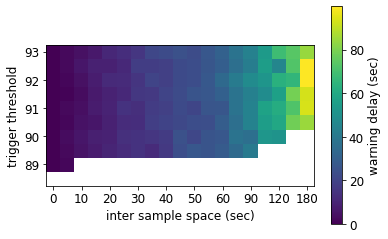

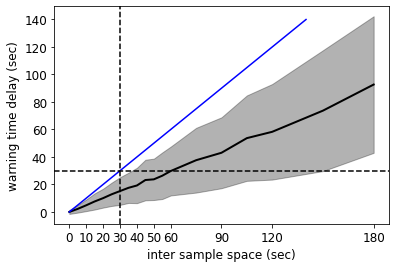

In [12]:
plotting.plot_rate_vs_alarm_time(alarm_times_sec, alarm_times_stds, inter_sample_sec, spo2_thresh)

**Q:** How often does data need to be collected (data update period) to detect changes in SpO2?\
**A:** The relationship between warning time delays and the data update period is sublinear. To ensure a warning time within 30 seconds of a SpO2 threshold cross, samples should be spaced at most 30 seconds apart. 

# Sampling Strategy

In the previous section, we presented a strategy for increasing energy efficiency by sampling for brief bouts spaced out. While this strategy has the potential to dramatically improve battery life, it comes at the expense of a potential delay between when the user’s SpO2 levels drop and when they are warned. While a brief delay (e.g. < 30 seconds) may be tolerable, it is also conceivable that this delay should be uncompromised. Can the device be made more energy efficient without compromising on warning time?  

Rather than sampling SpO2 continuously (which is energetically costly) or always sampling at a lower data collection rate (which compromises on low-SpO2 warning time delays), we consider a SpO2-aware sampling strategy that dynamically shifts into a more dense sampling regime when SpO2 values are moderately low. 

For example, consider the individual participant: Shunt-PPH case. When this individual’s SpO2 levels are in a safe, ’green’ range (say >94%), the data update period may be reduced. When the SpO2 levels drop into an ‘orange’ range (say 90-94%), the data collection will become continuous. Then, if the SpO2 level drops below the trigger threshold (say 90%), the device will trigger an alert while minimizing warning time delay. 

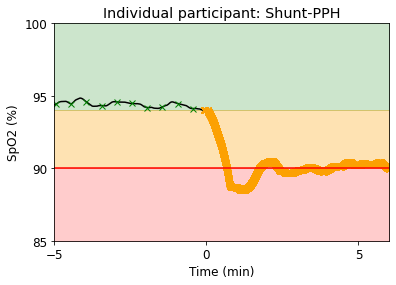

In [13]:
plotting.plot_color_range(data, params_pph_indi, 0.5, [94, 100], [90, 94], 90)

This strategy has the potential to dramatically increase energy efficiency while obtaining a minimum possible warning delay time. Our goal is to reduce battery use to 50% or less of the original use to accommodate removing one of the two coin batteries. This goal can be accomplished with a range of parameter settings. The below plots consider a sampling frequency of 25Hz and a sample duration of 5 seconds. The heat plot on the left plots the fraction of battery use (blue shades meet the 50% reduction goal) as a function of the percent time in the orange range and the inter-sample spacing. The right plot shows the same data for select values. One can see here that a relatively dense data collection rate during the green range (~30 seconds between samples) can still be accomplished as long as the orange range is set appropriately (say the bottom 30th percentile).

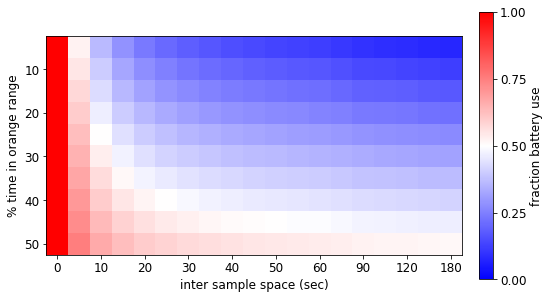

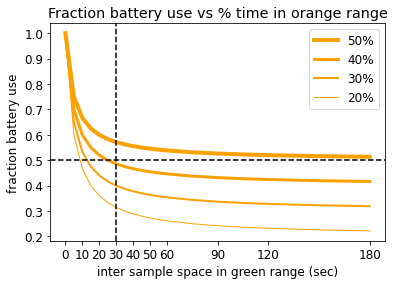

In [14]:

sample_dur_sec = 5
inter_sample_sec = np.array([0,5,10,15,20,25,30,35,40,45,50,55,60,75,90,105,120,150,180])
prcile_orange = np.arange(.05,.51,.05)

results = analysis.get_battery_fraction(sample_dur_sec, inter_sample_sec, prcile_orange)

plotting.plot_fraction_batt_vs_orange_time(results, inter_sample_sec, prcile_orange)


**Q:** Can the device be made more energy efficient without compromising on warning time?  
**A:** A SpO2-aware sampling strategy that decreases the data update period when the user is in a safe SpO2 range and increases the data update period when the user is in a moderate range can meet battery life targets while minimizing warning delays.

# Predicted Battery Efficiency

Assuming a 16 hour battery life of the current prototype, an 18 Hz sampling rate, and a 5 second sample duration yields the following battery life expectancy after one of the two coin batteries has been removed. Blue shaded values indicate parameter settings for the orange range upper bound and the inter sample spacing that meet the target battery life of greater than 1 day. The parameter choices recommended above would yield a battery life of approximately 30 hours.

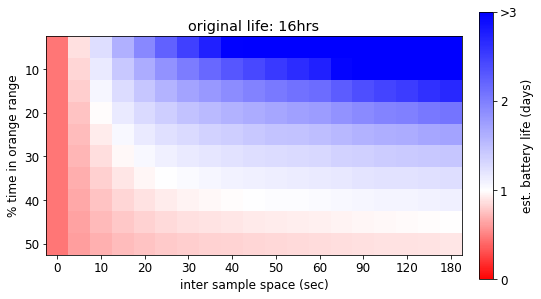

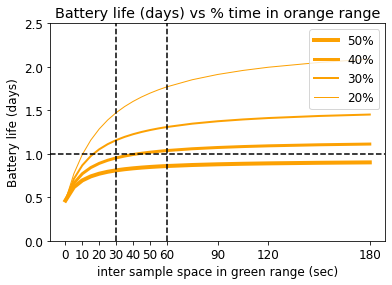

In [15]:

remove_battery = 0.5
current_life_16 = (16/24)
sample_18_hz = (25/18)


plotting.plot_battery_life_in_days(results, remove_battery*current_life_16*sample_18_hz, inter_sample_sec, prcile_orange,'original life: 16hrs')

Additionally, the OxiWear team has expressed confidence that the current prototype can reach a battery life of 24 hours by optimizing other parameters not discussed here (such as the LED amplitude. If so, the parameters recommended above would yield a battery life of approximately 45 hours with a single coin battery.

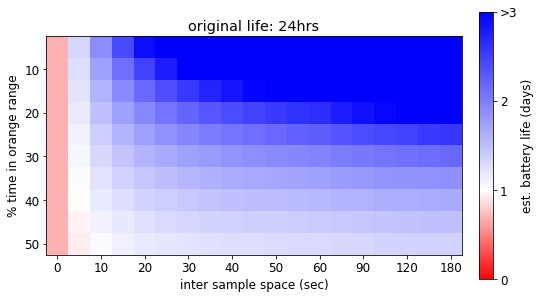

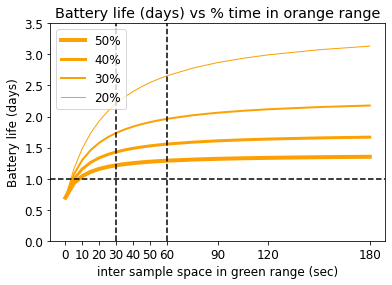

In [16]:
current_life_24 = (24/24)
plotting.plot_battery_life_in_days(results, remove_battery*current_life_24*sample_18_hz, inter_sample_sec, prcile_orange,'original life: 24hrs')

Thus, these parameters choices would meet the 24-48 hour target battery life expectancy with just one coin battery. Further, these choices would not compromise on signal fidelity and would minimize the time delay between a SpO2 drop and a user warning.